# LRP over CAP

#### Imports

In [4]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#enables acces to parent folder ()
import os
import sys
sys.path.append("../../..")

#other imports
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#varaible to add dummy dimension in a numpy array
na = np.newaxis

#modules import
import modules.sequential32 as sequential32
import modules.linear32 as linear32
import modules.convolution32 as convolution32
import modules.maxpool32 as maxpool32
import modules.rotation as rotation
import modules.avgCyclicPool2 as avgCyclicPool2


#print of plots within notebook
%matplotlib inline

#### Parameters

In [5]:
#number of samples for every trainning iteration
BATCH_SIZE = 5
#path to *.tfrecord files (data) in your computer
whole_data_path = '/home/tesla/Desktop/LRP/deep_hits_data/'
#path to pretrained model params
path='/home/tesla/Desktop/LRPbeta/Code_vFloat32_TB/weights/deephitsPoolMean/'

#### Functions to acces data base

To do this, you must have HiTS 2013 database in tfrecords format; train (1.2 million samples), validation (100k samples) and test (100k samples) set. You can finde them on __TODO__....

In [6]:
#funtion to get certain dataset tensor
def get_dataset_tensor(dataset):
    data_path = whole_data_path+dataset
    feature = {'image_raw': tf.FixedLenFeature([], tf.string),
               'label': tf.FixedLenFeature([], tf.int64),
               'snr': tf.FixedLenFeature([], tf.string)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path])
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['image_raw'], tf.float32)

    # Cast label data into int32
    label = tf.cast(features['label'], tf.int32)
    
    # Cast snr data into int32
    snr = tf.decode_raw(features['snr'], tf.float64)
    
    # Reshape image data into the original shape
    image = tf.reshape(image, [21, 21, 4])
    
    snr = tf.reshape(snr, [1])

    # Any preprocessing here ...

    # Creates batches by randomly shuffling tensors
    images, labels, snrs= tf.train.batch([image, label, snr],
                                    batch_size=BATCH_SIZE,
                                    capacity=100000,
                                    num_threads=1)
    return images, labels, snrs

def get_train_tensors():
    return get_dataset_tensor('snr_train.tfrecord')


def get_validation_tensors():
    return get_dataset_tensor('snr_validation.tfrecord')


def get_test_tensors():
    return get_dataset_tensor('snr_test.tfrecord')

#### Function to perform rotation
Define function for rotate tensor in [0,90,180,270] degrees

In [7]:
"""
given an image batch tensor as [batch_size,height,width,channels], 
generate 4 rotated versions in [0,90,180,270] degrees and concatenate them in batch dimension 

@param img_batch input tensor thath contains images
@return a [4*batch_size,height,width,channels] version of img_batch
"""
def augment_with_rotations(img_batch):   
    #perform rotations
    images90 = tf.map_fn(lambda x: tf.image.rot90(x, k=1), img_batch)
    images180 = tf.map_fn(lambda x: tf.image.rot90(x, k=2), img_batch)
    images270 = tf.map_fn(lambda x: tf.image.rot90(x, k=3), img_batch)
    
    #concatenate along first tensor dimension (batch dimension)
    return tf.concat([img_batch,
                         images90,
                         images180,
                         images270], 0)

#### Define network model

Deep-HiTS model for LRP framework, exact same as in paper. It considers:

1. Leaky-ReLU
2. He weights initialization
3. Biases initializated in 0.0
4. Stretching layer after convolutions that concatenates features

This consider a pretreined model. To be loaded, weights must be in a folder specified in variable 'path'.

In [8]:
def nn():
    return sequential32.Sequential([convolution32.Convolution(kernel_size=4,
                                                              output_depth=32, 
                                                              input_depth=4,
                                                              input_dim=27, act ='relu',
                                                              stride_size=1, pad='VALID', param_dir=path+'CNN1'),
                                    
                       convolution32.Convolution(kernel_size=3, output_depth=32,
                                                 stride_size=1, act ='relu',
                                                 pad='SAME', param_dir=path+'CNN2'),
                       
                       maxpool32.MaxPool(),

                       convolution32.Convolution(kernel_size=3, output_depth=64,
                                                 stride_size=1, act ='relu',
                                                 pad='SAME', param_dir=path+'CNN3'),
                                    
                       convolution32.Convolution(kernel_size=3, output_depth=64,
                                                 stride_size=1, act ='relu',
                                                 pad='SAME', param_dir=path+'CNN4'),
                                    
                       convolution32.Convolution(kernel_size=3, output_depth=64,
                                                 stride_size=1, act ='relu',
                                                 pad='SAME', param_dir=path+'CNN5'),
                       maxpool32.MaxPool(),
                       
                       linear32.Linear(64, act ='relu', keep_prob=keep_prob, 
                                       use_dropout = True, param_dir=path+'FC1'),
                                               
                       linear32.Linear(64, act ='relu', keep_prob=keep_prob, 
                                       use_dropout = True, param_dir=path+'FC2'),
                                    
                       avgCyclicPool2.CyclicAvgPool(),
                                    
                       linear32.Linear(2, act ='linear', param_dir=path+'FC3')])

#### Model I/O

In [9]:
#Dropout placeholder
keep_prob = tf.placeholder(tf.float32, name='keep-prob')

#Input place holders and variables
with tf.device('/cpu:0'):
    #train tensors variables, run them to get dataset sample
    images, labels, snr = get_train_tensors()
    #validation tensors variables
    validation_images, validation_labels, validation_snr = get_validation_tensors()
    #test tensors variables
    test_images, test_labels, test_snr = get_test_tensors()
    
    #place holder with default for input image, it enables to pass an specific tensor,
    #or call 'images' to get a train tensor
    images = tf.placeholder_with_default(images,
                                         (None, 21, 21, 4),
                                         'images_placeholder')
    #place holder with default for input label, it enables to pass an specific label,
    #or call 'labels' to get a train label
    labels = tf.placeholder_with_default(labels,
                                         None,
                                         'labels_placeholder')
    #label to one-hot
    one_hot_labels = tf.one_hot(labels, 2, dtype=tf.float32)
    #generate rotated images
    augmented_input = augment_with_rotations(images)
    #zero-pad images from 21x21 stamps to 27x27, to fit a 4x4 filter
    padded_input = tf.pad(augmented_input,
                          paddings=[
                              [0, 0],
                              [3, 3],
                              [3, 3],
                              [0, 0]])
    
    #input to model
    inp=padded_input
    #labels
    y_=one_hot_labels

#Model instance
with tf.variable_scope('model'):
        #instanciate model
        net = nn()       
        #feed-forward method and get score output. This iterates through layer in net object of class Sequiential
        score = net.forward(inp)
        #pass scores through softmax for network output ([0,1] probability)   
        y = tf.nn.softmax(score)
        #predicted classes
        y_pred_cls = tf.argmax(y, 1)
        #true classes
        y_true_cls = tf.argmax(y_, 1)

Forward Pass ... 
------------------------------------------------- 
input:: [None, 27, 27, 4]
conv2d_1:: [None, 24, 24, 32]
conv2d_2:: [None, 24, 24, 32]
maxpool_3:: [None, 12, 12, 32]
conv2d_4:: [None, 12, 12, 64]
conv2d_5:: [None, 12, 12, 64]
conv2d_6:: [None, 12, 12, 64]
maxpool_7:: [None, 6, 6, 64]
linear_8:: [None, 64]
linear_9:: [None, 64]
avgpool_10:: [None, 64]
linear_11:: [None, 2]
softmax:: [None, 2]

------------------------------------------------- 


#### Accuracy measurement

In [10]:
with tf.name_scope('accuracy'):  
        #compare predictions
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        #get accuracy
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Other performance measures
Explicit metrics to build Table II of paper

In [11]:
with tf.name_scope('performance_measures'):
    #confusion matrix values
    with tf.name_scope('values'):
        #true positives
        TP = tf.count_nonzero((y_pred_cls * y_true_cls))
        #true negative
        TN = tf.count_nonzero((y_pred_cls - 1) * (y_true_cls- 1))
        #false positives
        FP = tf.count_nonzero(y_pred_cls * (y_true_cls - 1))
        #false negatives
        FN = tf.count_nonzero((y_pred_cls - 1) * y_true_cls)
        
    with tf.name_scope('accuracy_func'):
            acc_mes = (TP+TN)/(TP+TN+FN+FP)
        
    with tf.name_scope('precision_func'):
            prec_mes = TP/(TP+FP)
            
    with tf.name_scope('recall_func'):
            rec_mes = TP/(TP+FN)      
            
    with tf.name_scope('f1_func'):
            f1_mes = 2 * prec_mes * rec_mes / (prec_mes + rec_mes) 

#### Init Tensorflow session

In [12]:
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

#### Init TensorBoard writers, Model variables and Tfrecords coordinators

In [13]:
#uncomment this only if you want to see models graph
#train_writer = tf.summary.FileWriter(os.path.join(SUMMARY_DIR, 'train'), sess.graph)

#initialization of model's variables
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)

# Create a coordinator and run all QueueRunner objects for parallel loading of tfrecords
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

#### Selection of class to be propagated
In this section we consider that network's raw output scores (output right before softmax layer) is propagated with LRP.

Whole output scores can be propagated, to see contribution from each class to the relevance heatmap at input, or just a single class output score can be propagated to know which input pixels are relevant to that class. This last option means to leave class score index value and every other value of the output score vector as 0. 
    
Mainly, there are 3 LRP propagation options:
1. Propagate full output score of the network which means that input heatmap will have negative and positive contributions from all classes 
2. Propagate predictied score, which will generate a heatmap with predicted class specific relevance. This means that the heatmap will depict which pixels are important for the classification made.
3. When the model missclassifies you can propagate true class score, and heatmap genereted will show in blue which pixels lower the classification score to that output.

Alternatively, softmax output can be LRP back propagated, but there is no consensus on what value should be propagated, a draw back of prapagating softmax is that negative score are turned to positive.

In [14]:
with tf.variable_scope('output_relevance'):
    
        #mask for predicted classes LRP
        y_pred_OH = tf.one_hot(indices=y_pred_cls, depth=2)
        #model prediction output_relevance
        y_rel_pred=score*y_pred_OH
        
        #true class output_relevance
        y_rel_true=score*tf.to_float(y_true_cls)
        
        #with this variable we can choose to propagate predicted score as 'y_rel_pred',
        #true class score as 'y_rel_true' or just the whole output score as 'score'
        y_rel_model=y_rel_pred
        
        #To LRP backpropagate softmax aoutput, simply replace 'score' variable by 'y' 

### Set LRP parameters

For more details on how to set this parameters, check 'PreTrained_MNIST_LRP_Example.npy' on MNIST folder

In [15]:
with tf.variable_scope('relevance'):

    
        #alpha-beta LRP
        relevance_method_ab='alphabeta'

        #alpha:1 - beta:0
        relevance_param_a1b0 = 1
        #alpha: 2 - beta:-1
        relevance_param_a2b1 = 2
        
        #epsilon LRP
        relevance_method_e='epsilon'
        
        #epsilon:1e-12
        relevance_param_e012 = 1e-12
        #epsilon:0.01
        relevance_param_e01 = 0.01
        #epsilon:1
        relevance_param_e1 = 1
        #epsilon:100
        relevance_param_e100 = 100
        
        #choose propagation rule that will take place
        #LRPa1b0 = net.lrp(y_rel_model, relevance_method_ab, relevance_param_a1b0)
        LRPa2b1 = net.lrp(y_rel_model, relevance_method_ab, relevance_param_a2b1)
        
        #LRPe012 = net.lrp(y_rel_model, relevance_method_e, relevance_param_e012)
        #LRPe01 = net.lrp(y_rel_model, relevance_method_e, relevance_param_e01)
        #LRPe1 = net.lrp(y_rel_model, relevance_method_e, relevance_param_e1)
        #LRPe100 = net.lrp(y_rel_model, relevance_method_e, relevance_param_e100)
        
        rel = LRPa2b1

Computing LRP ... 
------------------------------------------------- 
linear_11:: [None, 64]
avgpool_10:: [None, 64]
linear_9:: [None, 64]
linear_8:: [None, 2304]
maxpool_7:: [None, 12, 12, 64]
conv2d_6:: [None, 12, 12, 64]
conv2d_5:: [None, 12, 12, 64]
conv2d_4:: [None, 12, 12, 32]
maxpool_3:: [None, 24, 24, 32]
conv2d_2:: [None, 24, 24, 32]
conv2d_1:: [None, 27, 27, 4]

------------------------------------------------- 


### Here we define some functions to plot different images as in paper

In [16]:
def unRotations(img_batch):
    batch_size = tf.shape(img_batch)[0]/4
    N, h, w, depth = img_batch.get_shape().as_list()
    
    img_reshape = tf.reshape(img_batch, [4, -1, h, w, depth])
    
    img_1 = img_reshape[0,...]
    img_2 = tf.map_fn(lambda x: tf.image.rot90(x, k=4-1), img_reshape[1,...])
    img_3 = tf.map_fn(lambda x: tf.image.rot90(x, k=4-2), img_reshape[2,...])
    img_4 = tf.map_fn(lambda x: tf.image.rot90(x, k=4-3), img_reshape[3,...])
    # Might be useful to modify parallel_iterations,
    # back_prop and swap_memory params of tf.map_fn
    #img_batch[batch_size:2*batch_size,...] = tf.map_fn(lambda x: tf.image.rot90(x, k=4-1), img_batch[batch_size:2*batch_size,...])
    #img_batch = tf.map_fn(lambda x: tf.image.rot90(x, k=4-2), img_batch)
    #img_batch = tf.map_fn(lambda x: tf.image.rot90(x, k=4-3), img_batch)

    # TODO tf v1.0 has a different tf.concat call
    return tf.concat([img_1,img_2,img_3,img_4], 0)
    #return img_reshape
    #return img_1, img_2

unRot = unRotations(rel)

def pool(img_batch):
    N, h, w, depth = img_batch.get_shape().as_list()
    
    img_reshape = tf.reshape(img_batch, [4, -1, h, w, depth])
    
    #pooled_img = tf.nn.avg_pool3d(img_reshape,  [4,1,1,1,1], [4,1,1,1,1], 'SAME', name='rotational_pool')
    # Pooling is not yet supported on the batch dimension.
    
    pooled_img = tf.reduce_mean(img_reshape, [0])
    
    return pooled_img



In [17]:
import matplotlib.cm

"""
input a HeightxWidthxChannels relevance image and normalize it using all values
return Channels jet heatmaps as RGB images (Channels images HeightxWidthx3 = [Channels,Height,Width,3])
"""
def normalize_through_channels(r):
    if len(r.shape)<3:
        r = r[...,np.newaxis]
    R=r[3:24,3:24,:]
     
    R = R / np.max(np.abs(R))
     
    R = (R + 1.)/2.
    
    cmap = eval('matplotlib.cm.{}'.format('jet'))
    
    result_list = []
    for i in range(r.shape[-1]):
        hm = R[...,i]
        rgb = cmap(hm.flatten())[...,0:3].reshape([hm.shape[0],hm.shape[1],3])
        result_list.append(rgb)
        #plt.imshow(rgb)
        #plt.show()
    
    return np.array(result_list)   


def normalize_through_all(r):
    if len(r.shape)<4:
        r = r[...,np.newaxis]
    R=r[:,3:24,3:24,:]
     
    R = R / np.max(np.abs(R))
     
    R = (R + 1.)/2.
    
    return R

def plot_4_relevances(images, titles=None):
    #fill titles with blanks
    if titles==None:
        titles = []
        for i in range(4):
            titles.append('')
            
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i,:,:,:], interpolation='nearest')
        plt.axis('off')
        plt.title(titles[i])
    plt.show()
        
        
def plot_input_image(images):
    #fill titles with blanks
    titles = ['Template', 'Science', 'Diff', 'SNR Diff']
            
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[:,:,i], interpolation='nearest', cmap='gray')
        plt.axis('off')
        plt.title(titles[i])
    plt.show()
    
def plot_and_norm_4_rel(relevance):
    plot_4_relevances(normalize_through_channels(relevance))
    
def get_rel_channels_RGB(singleRel):
    if len(singleRel.shape)<3:
        singleRel = singleRel[...,np.newaxis]
    cmap = eval('matplotlib.cm.{}'.format('jet'))
    result_list = []
    for i in range(singleRel.shape[-1]):
        hm = singleRel[...,i]
        rgb = cmap(hm.flatten())[...,0:3].reshape([hm.shape[0],hm.shape[1],3])
        result_list.append(rgb)
        #plt.imshow(rgb)
        #plt.show()
    
    return np.array(result_list)

#input relevances with rotations on batch
def plot_and_norm_allRel(rel):
    norm_rel = normalize_through_all(rel)
    titles = ["No Rotation", "90°", "180°", "270°"]
    for i in range(rel.shape[0]):
        print(titles[i])
        plot_4_relevances(get_rel_channels_RGB(norm_rel[i,...]))
        
def normalize_img(R):
    R = R / np.max(np.abs(R))
     
    R = (R + 1.)/2.
    
    return R
    
def plot_final_relevance_by_index(imp_im, imp_lb, imp_snr, index, plot_mean=True,
                        plot_rot_norm_all=True, plot_single_rot_norm=True):
        
        titles = ["No Rotation", "90°", "180°", "270°"]
        labels_name = ["bogus", "real"]
        
        #get relevances
        inp_dict = {images:imp_im[index,...][na,...], labels:imp_lb[index], keep_prob:1.0}
        cyclic_unslicing, rot_pool, y_predicted = sess.run([rel, pool(unRot), y_pred_cls], feed_dict=inp_dict)
         
        #plot samples
        print("Sample: %.0f - SNR: %.3f - Label: %s - Predicted: %s" % (index, imp_snr[index],
                                                                         labels_name[imp_lb[index]],
                                                                            labels_name[int(y_predicted)]))
        plot_input_image(imp_im[index,...])
        #plot pooled relevances
        if plot_mean:
            print("---Mean Pool---")
            plot_and_norm_4_rel(rot_pool[0,...])
        #plot rotations all normd together
        if plot_rot_norm_all:
            print("---All normed Together---")
            plot_and_norm_allRel(cyclic_unslicing)
        #plot rotations normed by rot
        if plot_single_rot_norm:
            print("---Normed by Rotation---")
            for i in range(4):
                print(titles[i])
                plot_and_norm_4_rel(cyclic_unslicing[i,...])

def plot_all_relevances(imp_im, imp_lb, imp_snr, index = None, plot_mean=True,
                        plot_rot_norm_all=True, plot_single_rot_norm=True):
    
    if index!=None:
        plot_final_relevance_by_index(imp_im, imp_lb, imp_snr, index, plot_mean,
                        plot_rot_norm_all, plot_single_rot_norm)
        
    else:
        for i in range(imp_im.shape[0]):
            plot_final_relevance_by_index(imp_im, imp_lb, imp_snr, i, plot_mean,
                        plot_rot_norm_all, plot_single_rot_norm)   

### Get a sample batch to plot

In [18]:
images_array, labels_array, snr_array = sess.run((
            test_images,
            test_labels,
            test_snr))

# Plot batch examples

Sample: 0 - SNR: 8.397 - Label: bogus - Predicted: bogus


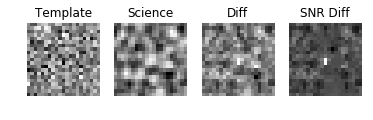

---Mean Pool---


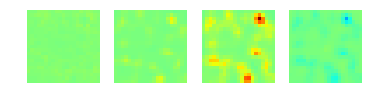

---All normed Together---
No Rotation


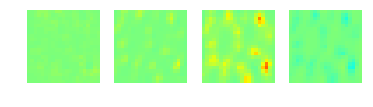

90°


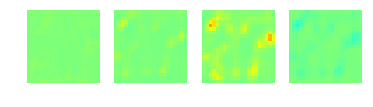

180°


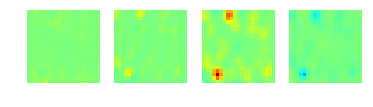

270°


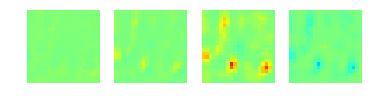

Sample: 1 - SNR: -8.254 - Label: bogus - Predicted: bogus


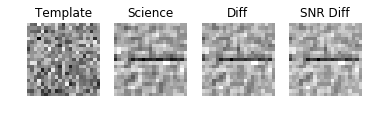

---Mean Pool---


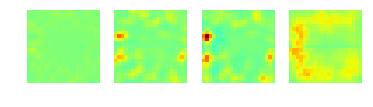

---All normed Together---
No Rotation


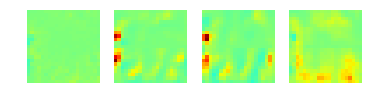

90°


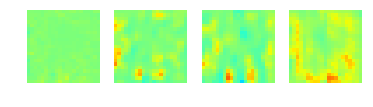

180°


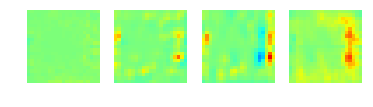

270°


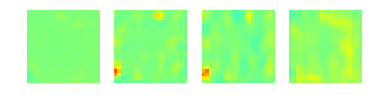

Sample: 2 - SNR: -13.205 - Label: bogus - Predicted: bogus


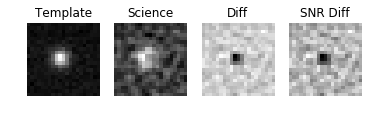

---Mean Pool---


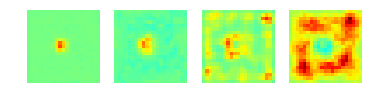

---All normed Together---
No Rotation


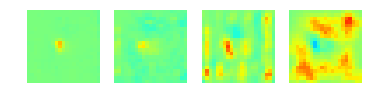

90°


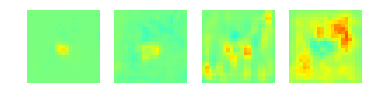

180°


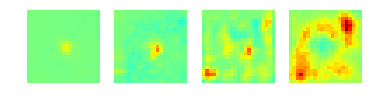

270°


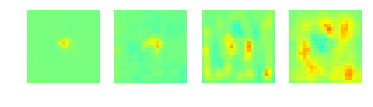

Sample: 3 - SNR: 48.077 - Label: real - Predicted: real


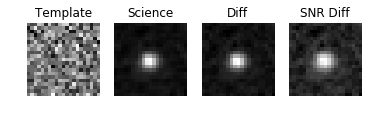

---Mean Pool---


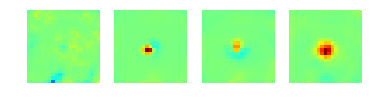

---All normed Together---
No Rotation


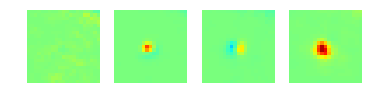

90°


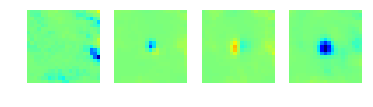

180°


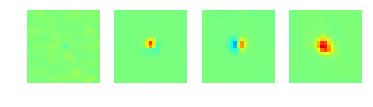

270°


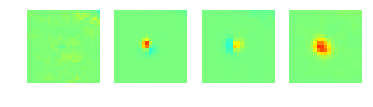

Sample: 4 - SNR: 22.494 - Label: real - Predicted: real


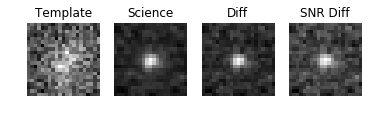

---Mean Pool---


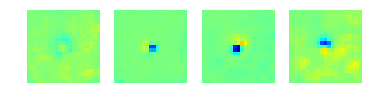

---All normed Together---
No Rotation


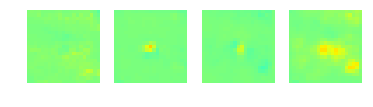

90°


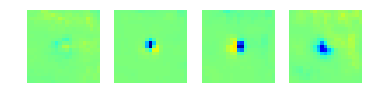

180°


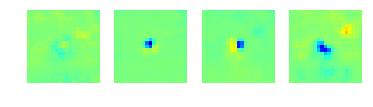

270°


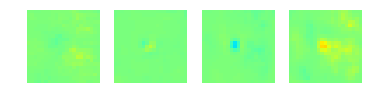

In [19]:
plot_all_relevances(images_array, labels_array, snr_array, plot_mean=True,
                        plot_rot_norm_all=True, plot_single_rot_norm=False)

# Plot specific sample from batch

Sample: 2 - SNR: -13.205 - Label: bogus - Predicted: bogus


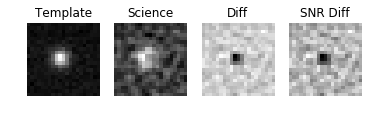

---Mean Pool---


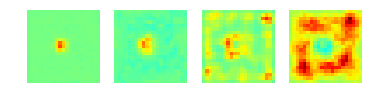

---All normed Together---
No Rotation


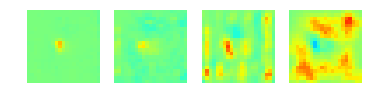

90°


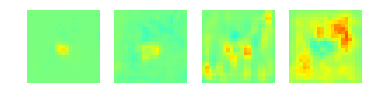

180°


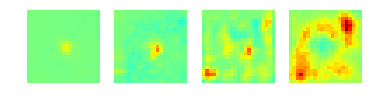

270°


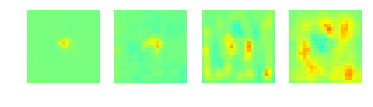

In [20]:
plot_all_relevances(images_array, labels_array, snr_array, index = 2, plot_mean=True,
                        plot_rot_norm_all=True, plot_single_rot_norm=False)